<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/OpenMM_Scripting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**NOTE**: Code must be run twice to work

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

!mamba install -c conda-forge ambertools -y

✨🍰✨ Everything looks OK!

Looking for: ['ambertools']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed



In [3]:
!git clone https://github.com/Iourarum/GOPY.git
%cd GOPY
!python GOPY.py generate_PG 10 10 graphene.pdb
!python GOPY.py generate_GO graphene.pdb 2 4 8 functionalized.pdb

Cloning into 'GOPY'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 197 (delta 39), reused 18 (delta 18), pack-reused 150 (from 1)
Receiving objects: 100% (197/197), 9.50 MiB | 35.38 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/GOPY
done.
GOPY.py
generate_GO
graphene.pdb
2
4
8
functionalized.pdb
Left to add:  cooh:  2 epoxy:  4 hydroxyl:  8
Left to add:  cooh:  2 epoxy:  3 hydroxyl:  8
Left to add:  cooh:  2 epoxy:  3 hydroxyl:  7
Left to add:  cooh:  1 epoxy:  3 hydroxyl:  7
Left to add:  cooh:  0 epoxy:  3 hydroxyl:  7
Left to add:  cooh:  0 epoxy:  2 hydroxyl:  7
Left to add:  cooh:  0 epoxy:  1 hydroxyl:  7
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  7
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  6
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  5
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  4
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  3
Left to add:  cooh:  0 epoxy:  0

In [4]:
!wget https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/GGG.lib
!wget https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/C1A.lib
!wget https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/E1A.lib
!wget https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/H1A.lib
!mkdir -p FRCMOD
!wget -P FRCMOD https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/FRCMOD/GO.frcmod

--2025-02-11 18:02:13--  https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/GGG.lib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [text/plain]
Saving to: ‘GGG.lib’

GGG.lib             100%[===================>]   1.04K  --.-KB/s    in 0s      

2025-02-11 18:02:13 (33.1 MB/s) - ‘GGG.lib’ saved [1063/1063]

--2025-02-11 18:02:13--  https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/C1A.lib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1627 (1.6K) [text/plain]
Saving to: ‘C1A.lib’

C1

In [5]:
!pip install openmm
!pip install MDAnalysis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 108.8 MB/s eta 0:00:00


New

In [6]:
import os


leap_content_stage1 = f"""\
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 20.0
saveamberparm mol mol_solv.prmtop mol_solv.inpcrd
quit
"""
with open('leap_stage1.in', 'w') as f:
    f.write(leap_content_stage1)

os.system('tleap -f leap_stage1.in')


os.system("grep 'Volume:' leap.log > temp_vol.txt")
with open("temp_vol.txt", 'r') as f:
    for line in f:
        vol = float(line.split()[1])
vol_lit = vol * 1e-27

atom_factor = 6.022e23 * 0.15
num_Hg = int(vol_lit * atom_factor)
num_Cl = 2 * num_Hg

print(f"Computed ion counts -> Hg: {num_Hg}, Cl: {num_Cl}")


leap_content_stage2 = f"""\
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 5.0
addIonsRand mol HG {num_Hg} Cl- {num_Cl}
saveamberparm mol mol_solv_ions.prmtop mol_solv_ions.inpcrd
savepdb mol mol_solv.pdb
quit
"""
with open('leap_stage2.in', 'w') as f:
    f.write(leap_content_stage2)

os.system('tleap -f leap_stage2.in')

!tleap -f leap_stage2.in

Computed ion counts -> Hg: 15, Cl: 30
-I: Adding /usr/local/dat/leap/prep to search path.
-I: Adding /usr/local/dat/leap/lib to search path.
-I: Adding /usr/local/dat/leap/parm to search path.
-I: Adding /usr/local/dat/leap/cmd to search path.
-f: Source leap_stage2.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./leap_stage2.in
----- Source: /usr/local/dat/leap/cmd/leaprc.protein.ff14SB
----- Source of /usr/local/dat/leap/cmd/leaprc.protein.ff14SB done
Log file: ./leap.log
Loading parameters: /usr/local/dat/leap/parm/parm10.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA
Loading parameters: /usr/local/dat/leap/parm/frcmod.ff14SB
Reading force field modification type file (frcmod)
Reading title:
ff14SB protein backbone and sidechain parameters
Loading library: /usr/local/dat/leap/lib/amino12.lib
Loading library: /usr/local/dat/leap/lib/aminoct12.lib
Loading library: /usr/local/dat/leap/lib/aminont12.lib
----- Source: /usr/local/dat/leap/cmd/leaprc.

In [19]:
!pip install py3Dmol

In [31]:
import warnings
warnings.filterwarnings('ignore')
import py3Dmol

show_box = True
box_opacity = 0.3

def show_pdb(show_box=False):
    view = py3Dmol.view(width=800, height=600)
    pdb_str = open('/content/GOPY/mol_solv.pdb', 'r').read()
    view.addModel(pdb_str, 'pdb')

    view.addStyle({'resn': 'HG'}, {
        'stick': {'color': 'red', 'radius': 0.3},
        'sphere': {'color': 'red', 'radius': 0.5}
    })

    view.addStyle({'or': [{'resn': 'Cl'}, {'resn': 'Cl-'}]}, {
        'stick': {'color': 'blue', 'radius': 0.3},
        'sphere': {'color': 'blue', 'radius': 0.5}
    })

    view.addStyle({'and': [
        {'not': {'resn': 'HG'}},
        {'not': {'or': [{'resn': 'Cl'}, {'resn': 'Cl-'}]}},
        {'not': {'resn': 'HOH'}}
    ]}, {
        'cartoon': {'color': 'sandybrown', 'thickness': 1}
    })

    view.setViewStyle({'style': 'outline', 'color': 'black', 'width': 0.1})

    if show_box:
        view.addSurface(py3Dmol.SAS, {'opacity': box_opacity, 'color': 'white'})

    view.zoomTo()
    return view

show_pdb(show_box).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [27]:
import os
import py3Dmol

pdb_file = os.path.join(os.getcwd(), "mol_solv.pdb")

with open(pdb_file, 'r') as f:
    pdb_data = f.read()

view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_data, "pdb")

# Apply styles
view.setStyle({'stick': {'colorscheme': 'cyanCarbon', 'radius': 0.3}})
view.addStyle({'sphere': {'radius': 0.5}}, {'resn': 'HG'})
view.addStyle({'sphere': {'radius': 0.3, 'color': 'red'}}, {'resn': 'CL'})

# Enhance visualization
view.setViewStyle({'style': 'outline', 'color': 'black', 'width': 0.1})
view.zoomTo()

# Show the visualization
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [32]:
# Modified sorption isotherm code with molarity-based initialization
import os
from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PDBReporter, PME, HBonds, DCDReporter
from openmm import LangevinMiddleIntegrator, Platform
from openmm.unit import kelvin, picosecond, nanometer, picoseconds
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.signal import find_peaks
from scipy.spatial import cKDTree
from scipy.constants import Avogadro
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

def run_simulation_and_analyze(molarity, mass_adsorbent=1.0):
    # Stage 1: Determine system volume
    leap_stage1 = f"""\
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 20.0
saveamberparm mol mol_solv_stage1.prmtop mol_solv_stage1.inpcrd
quit
"""
    with open('leap_stage1.in', 'w') as f:
        f.write(leap_stage1)
    os.system('tleap -f leap_stage1.in')

    # Extract volume and calculate ion counts
    os.system("grep 'Volume:' leap.log > temp_vol.txt")
    with open("temp_vol.txt", 'r') as f:
        vol = float(f.readline().split()[1])

    vol_lit = vol * 1e-27  # Convert Å³ to liters
    num_Hg = int(vol_lit * molarity * Avogadro)
    num_Cl = 2 * num_Hg

    # Stage 2: Add ions and run simulation
    leap_stage2 = f"""\
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 5.0
addIonsRand mol HG {num_Hg} Cl- {num_Cl}
saveamberparm mol mol_solv_ions.prmtop mol_solv_ions.inpcrd
quit
"""
    with open('leap_stage2.in', 'w') as f:
        f.write(leap_stage2)
    os.system('tleap -f leap_stage2.in')

    # Simulation setup
    prmtop = AmberPrmtopFile('mol_solv_ions.prmtop')
    inpcrd = AmberInpcrdFile('mol_solv_ions.inpcrd')

    system = prmtop.createSystem(nonbondedMethod=PME,
                                nonbondedCutoff=1.0*nanometer,
                                constraints=HBonds)
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
    platform = Platform.getPlatformByName('CPU')
    simulation = Simulation(prmtop.topology, system, integrator, platform)
    simulation.context.setPositions(inpcrd.positions)
    simulation.minimizeEnergy()

    # Production dynamics
    simulation.reporters.append(DCDReporter('trajectory.dcd', 100))
    simulation.step(5000)

    # Analysis
    u = mda.Universe('mol_solv_ions.prmtop', 'trajectory.dcd')
    protein = u.select_atoms('resname GGG E1A H1A C1A')
    HG = u.select_atoms('name HG')

    # RDF analysis
    rdf_calc = InterRDF(protein, HG, range=(0.0, 12.0), nbins=120)
    rdf_calc.run()

    # Adsorption calculation
    adsorbed = 0
    total_frames = 0
    box_dims = u.trajectory[0].dimensions[:3]

    for ts in u.trajectory:
        tr_ref = cKDTree(protein.positions)
        tr_tg = cKDTree(HG.positions)
        sdm = tr_ref.sparse_distance_matrix(tr_tg, max_distance=5.0, output_type='coo_matrix')
        adsorbed += len(np.unique(sdm.col))
        total_frames += 1

    avg_adsorbed = adsorbed / total_frames if total_frames > 0 else 0.0

    # Calculate isotherm values
    volume_A3 = box_dims[0] * box_dims[1] * box_dims[2]
    volume_L = volume_A3 * 1e-27  # Correct conversion to liters
    MW_HG = 200.59  # Mercury atomic weight

    C_e = (num_Hg - avg_adsorbed) * MW_HG / (Avogadro * volume_L) * 1e3  # mg/L
    q_e = (avg_adsorbed * MW_HG) / mass_adsorbent * 1e3  # mg/g

    return C_e, q_e, rdf_calc.bins, rdf_calc.rdf

Molarity: 0.05 M, Ce: -208304.96 mg/L, qe: 2017935.40 mg/g
Molarity: 0.1 M, Ce: -203749.59 mg/L, qe: 1973805.60 mg/g
Molarity: 0.15 M, Ce: 0.00 mg/L, qe: 200590.00 mg/g
Molarity: 0.2 M, Ce: 414.13 mg/L, qe: 196578.20 mg/g


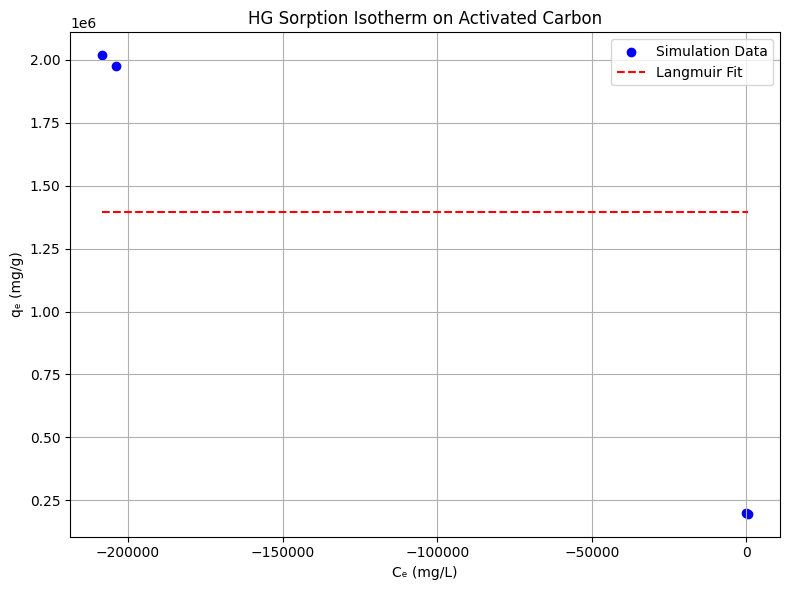

Langmuir fit parameters:
q_max = 1396106.39 mg/g
K_L = -210734.8943 L/mg


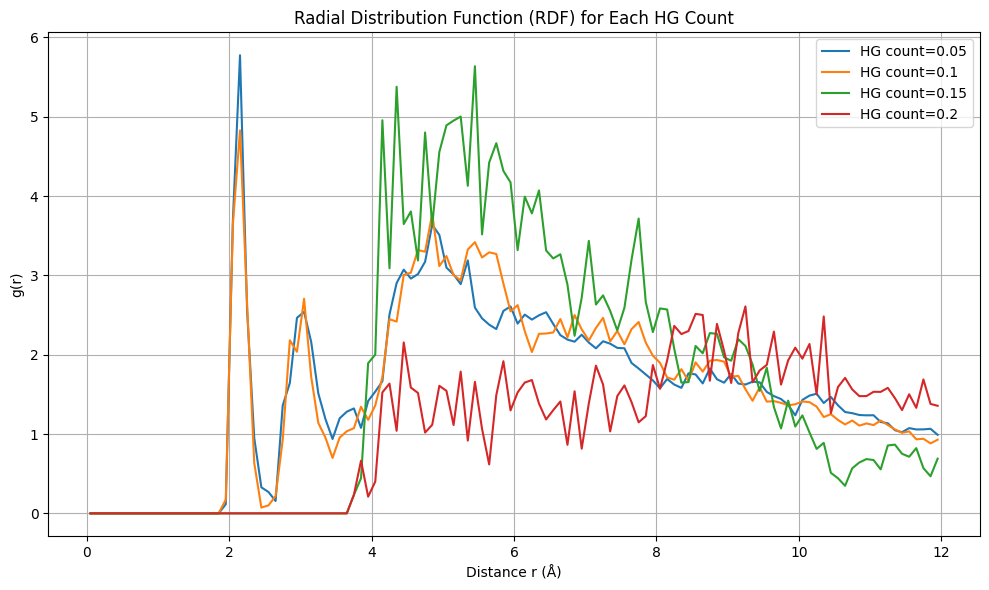

In [33]:
# Main execution loop for molarity trials
molarities = [0.05, 0.10, 0.15, 0.20]  # Molar concentrations to test
Ce_values = []
qe_values = []
rdf_data = []

for molarity in molarities:
    Ce, qe, r, rdf = run_simulation_and_analyze(molarity)
    Ce_values.append(Ce)
    qe_values.append(qe)
    rdf_data.append((molarity, r, rdf))
    print(f"Molarity: {molarity} M, Ce: {Ce:.2f} mg/L, qe: {qe:.2f} mg/g")

with open('sorption_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['HG_count', 'Ce (mg/L)', 'q_e (mg/g)'])
    for count, Ce, qe in zip(HG_counts, Ce_values, qe_values):
        writer.writerow([count, Ce, qe])

def langmuir(C, q_max, K_L):
    return (q_max * K_L * C) / (1 + K_L * C)

if len(Ce_values) > 2:
    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1], maxfev=10000)
    q_max, K_L = params

    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)

    plt.figure(figsize=(8, 6))
    plt.scatter(Ce_values, qe_values, c='b', label='Simulation Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Cₑ (mg/L)')
    plt.ylabel('qₑ (mg/g)')
    plt.title('HG Sorption Isotherm on Activated Carbon')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Langmuir fit parameters:\nq_max = {q_max:.2f} mg/g\nK_L = {K_L:.4f} L/mg")

# RDF plotting for each trial
plt.figure(figsize=(10, 6))
for count, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'HG count={count}')
plt.xlabel('Distance r (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF) for Each HG Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

-I: Adding /usr/local/dat/leap/prep to search path.
-I: Adding /usr/local/dat/leap/lib to search path.
-I: Adding /usr/local/dat/leap/parm to search path.
-I: Adding /usr/local/dat/leap/cmd to search path.
-f: Source tleap.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleap.in
----- Source: /usr/local/dat/leap/cmd/leaprc.protein.ff14SB
----- Source of /usr/local/dat/leap/cmd/leaprc.protein.ff14SB done
Log file: ./leap.log
Loading parameters: /usr/local/dat/leap/parm/parm10.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA
Loading parameters: /usr/local/dat/leap/parm/frcmod.ff14SB
Reading force field modification type file (frcmod)
Reading title:
ff14SB protein backbone and sidechain parameters
Loading library: /usr/local/dat/leap/lib/amino12.lib
Loading library: /usr/local/dat/leap/lib/aminoct12.lib
Loading library: /usr/local/dat/leap/lib/aminont12.lib
----- Source: /usr/local/dat/leap/cmd/leaprc.water.tip3p
----- Source of /usr/local/dat/leap/cm

/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


HG count: 20, Ce: 2.81 mg/L, qe: 200590.00 mg/g
HG count: 40, Ce: 5.77 mg/L, qe: 200590.00 mg/g
HG count: 60, Ce: 8.68 mg/L, qe: 272802.40 mg/g
HG count: 80, Ce: 11.40 mg/L, qe: 593746.40 mg/g


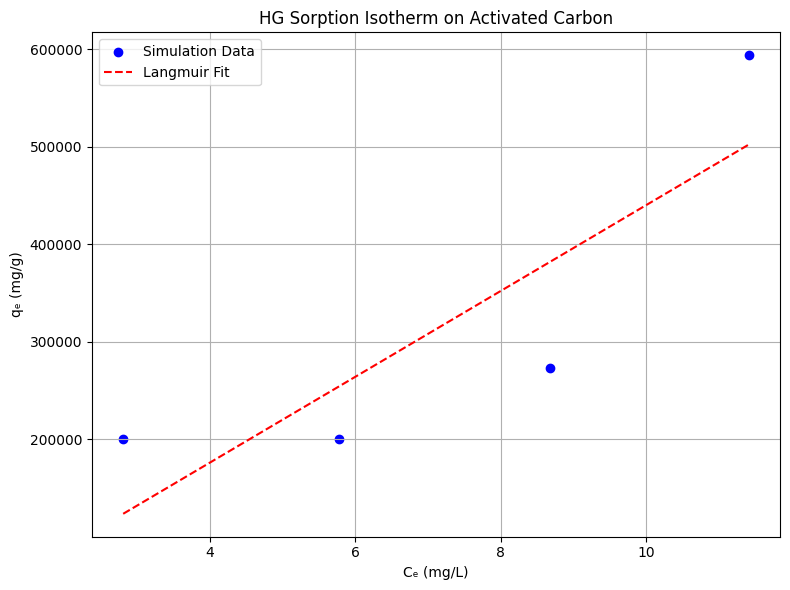

Langmuir fit parameters:
q_max = 78176052624.48 mg/g
K_L = 0.0000 L/mg


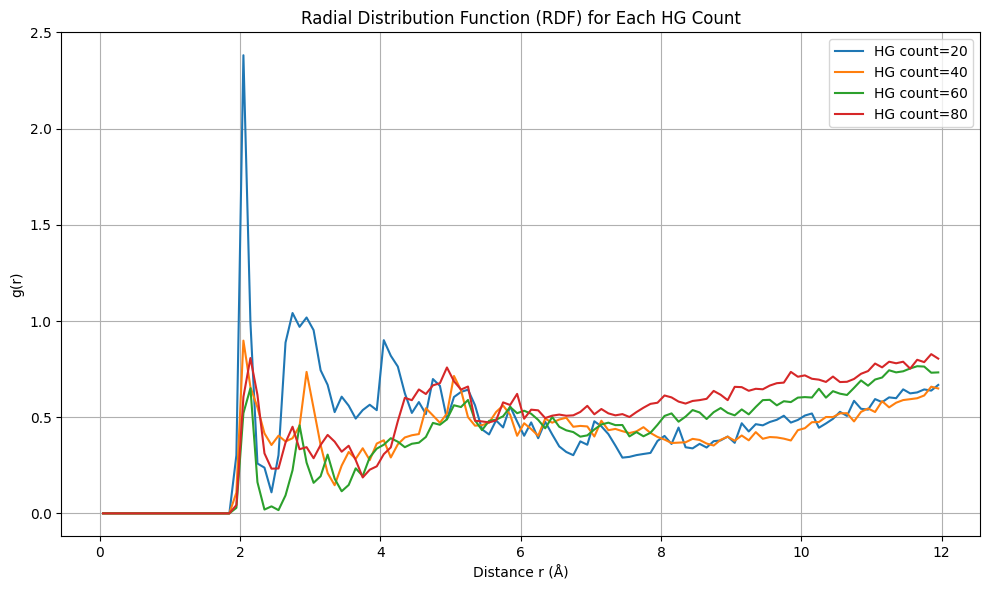

In [9]:
#Thank you to u/SocraticHope and u/qfbros on r/comp_chem for helping me debug my tleap script :)

tleap_script = """
source leaprc.protein.ff14SB

source leaprc.water.tip3p

loadAmberParams frcmod.ions234lm_126_tip3p
list
solv = createUnit solv

solvateBox solv TIP3PBOX 20.0

addIons2 solv HG 1

addIons2 solv Cl- 2

saveAmberParm solv solv.prmtop solv.inpcrd

quit
"""

with open('tleap.in', 'w') as f:
    f.write(tleap_script)

!tleap -f tleap.in

from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PDBReporter, PME, HBonds, DCDReporter
from openmm import LangevinMiddleIntegrator, Platform
from openmm.unit import kelvin, picosecond, nanometer, picoseconds
import os, numpy as np, MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.signal import find_peaks
from scipy.spatial import cKDTree
from scipy.constants import Avogadro

def run_simulation_and_analyze(HG_count, box_dims, mass_adsorbent=1.0, initial_counts=None):
    leap_content = f"""source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 5.0
addIons2 mol HG {HG_count}
addIons2 mol Cl- {2*HG_count}
saveamberparm mol mol_solv.prmtop mol_solv.inpcrd
quit
"""
    with open('leap.in', 'w') as f:
        f.write(leap_content)
    os.system('tleap -f leap.in')

    prmtop = AmberPrmtopFile('mol_solv.prmtop')
    inpcrd = AmberInpcrdFile('mol_solv.inpcrd')
    topology = prmtop.topology
    positions = inpcrd.positions

    system = prmtop.createSystem(nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
    platform = Platform.getPlatformByName('CPU')
    simulation = Simulation(topology, system, integrator, platform)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()

    # Use DCDReporter to generate a trajectory file with consistent atom counts
    simulation.reporters.append(DCDReporter('trajectory.dcd', 100))
    simulation.step(5000)

    # Load the trajectory using MDAnalysis with the same topology
    u = mda.Universe('mol_solv.prmtop', 'trajectory.dcd')
    for ts in u.trajectory:
        ts.dimensions = [box_dims[0], box_dims[1], box_dims[2], 90.0, 90.0, 90.0]
    u.trajectory.rewind()

    protein = u.select_atoms('resname GGG E1A H1A C1A')
    HG = u.select_atoms('name HG')

    # RDF computation
    r_min, r_max = 0.0, 12.0
    rdf_calc = InterRDF(protein, HG, range=(r_min, r_max), nbins=120)
    rdf_calc.run()

    peaks, _ = find_peaks(rdf_calc.rdf)
    if len(peaks) > 0:
        first_peak = peaks[0]
        inverted = -rdf_calc.rdf
        minima, _ = find_peaks(inverted, distance=10)
        cands = minima[minima > first_peak]
        r_cut = rdf_calc.bins[cands[0]] if len(cands) > 0 else r_max
    else:
        r_cut = r_max

    adsorbed = 0
    total_frames = 0
    ref_group = protein
    target_group = HG
    for ts in u.trajectory:
        p_ref = ref_group.positions
        p_tg = target_group.positions
        tr_ref = cKDTree(p_ref)
        tr_tg = cKDTree(p_tg)
        sdm = tr_ref.sparse_distance_matrix(tr_tg, max_distance=r_cut, output_type='coo_matrix')
        col_ids = np.unique(sdm.col)
        adsorbed += len(col_ids)
        total_frames += 1

    avg_adsorbed = adsorbed / total_frames if total_frames > 0 else 0.0

    MW_HG = 200.59
    if initial_counts is None:
        initial_counts = {'HG': HG_count}
    N_initial = initial_counts['HG']

    volume_A3 = box_dims[0] * box_dims[1] * box_dims[2]
    volume_L = volume_A3 * 1e-24
    N_unads = N_initial - avg_adsorbed
    C_e = (N_unads * MW_HG / Avogadro) / volume_L * 1e3  # mg/L
    q_e = (avg_adsorbed * MW_HG) / mass_adsorbent * 1e3  # mg/g

    return C_e, q_e, rdf_calc.bins, rdf_calc.rdf

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

HG_counts = [20, 40, 60, 80]
box_dims = (150.0, 150.0, 100.0)
Ce_values = []
qe_values = []
rdf_data = []

for count in HG_counts:
    Ce, qe, r, rdf = run_simulation_and_analyze(count, box_dims, mass_adsorbent=1.0, initial_counts={'HG': count})
    Ce_values.append(Ce)
    qe_values.append(qe)
    rdf_data.append((count, r, rdf))
    print(f"HG count: {count}, Ce: {Ce:.2f} mg/L, qe: {qe:.2f} mg/g")

with open('sorption_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['HG_count', 'Ce (mg/L)', 'q_e (mg/g)'])
    for count, Ce, qe in zip(HG_counts, Ce_values, qe_values):
        writer.writerow([count, Ce, qe])

def langmuir(C, q_max, K_L):
    return (q_max * K_L * C) / (1 + K_L * C)

if len(Ce_values) > 2:
    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1], maxfev=10000)
    q_max, K_L = params

    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)

    plt.figure(figsize=(8, 6))
    plt.scatter(Ce_values, qe_values, c='b', label='Simulation Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Cₑ (mg/L)')
    plt.ylabel('qₑ (mg/g)')
    plt.title('HG Sorption Isotherm on Activated Carbon')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Langmuir fit parameters:\nq_max = {q_max:.2f} mg/g\nK_L = {K_L:.4f} L/mg")

# RDF plotting for each trial
plt.figure(figsize=(10, 6))
for count, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'HG count={count}')
plt.xlabel('Distance r (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF) for Each HG Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Updated params

/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/rdf.py:347: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/rdf.py:339: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)


Initial C0: 4.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g
Initial C0: 8.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g
Initial C0: 12.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g
Initial C0: 16.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g
Initial C0: 20.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g


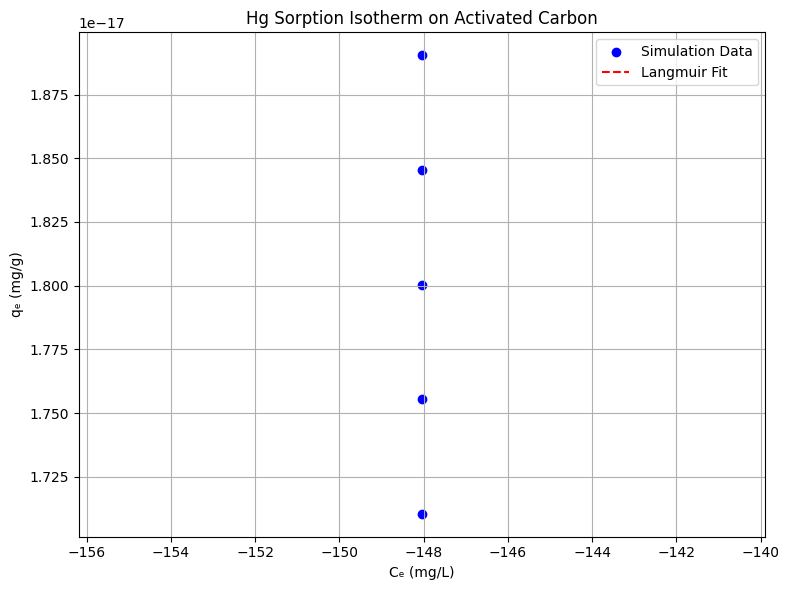

Langmuir fit parameters:
  q_max = 0.00 mg/g
  K_L = 0.1000 L/mg


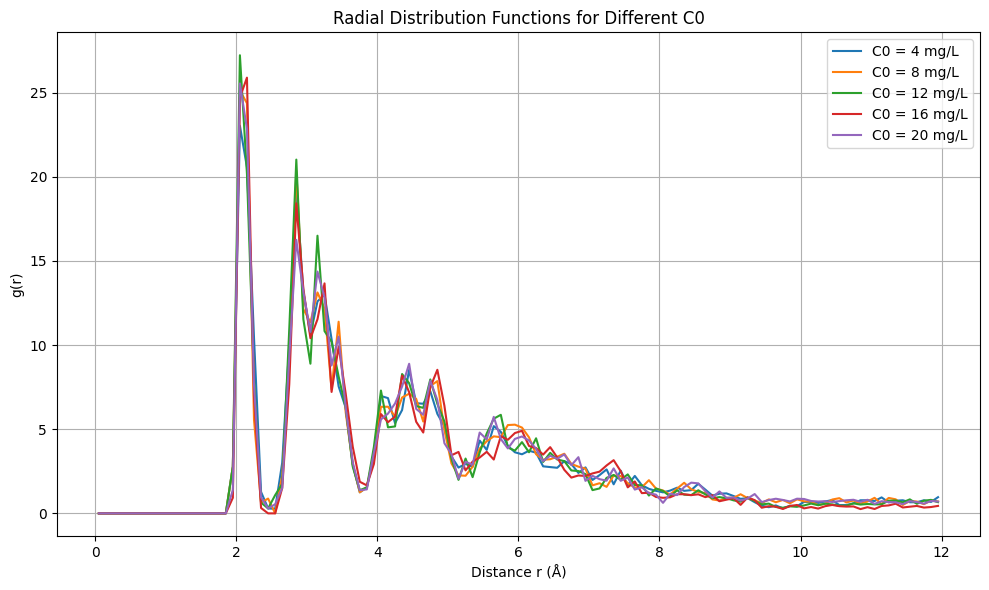

In [7]:
#!/usr/bin/env python
import os, numpy as np, MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.signal import find_peaks
from scipy.spatial import cKDTree
from scipy.constants import Avogadro
from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PDBReporter, PME, HBonds, DCDReporter
from openmm import LangevinMiddleIntegrator, Platform
from openmm.unit import kelvin, picosecond, nanometer, picoseconds
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

# --- Constants & Parameters ---
MW_Hg = 200.59  # g/mol
mass_adsorbent = 0.02
initial_concs = [4, 8, 12, 16, 20]
box_dims = (150.0, 150.0, 100.0)
volume_A3 = box_dims[0] * box_dims[1] * box_dims[2]
V = volume_A3 * 1e-27  # L

def run_simulation_and_analyze(C0, box_dims, mass_adsorbent):
    N_initial = int(round((C0 * V * Avogadro) / (MW_Hg * 1e3)))
    Cl_count = 2 * N_initial

    leap_content = f"""
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 5.0
addIons2 mol HG {N_initial}
addIons2 mol Cl- {Cl_count}
saveamberparm mol mol_solv.prmtop mol_solv.inpcrd
quit
"""
    with open('leap.in', 'w') as f:
        f.write(leap_content)
    os.system('tleap -f leap.in')

    prmtop = AmberPrmtopFile('mol_solv.prmtop')
    inpcrd = AmberInpcrdFile('mol_solv.inpcrd')
    topology = prmtop.topology
    positions = inpcrd.positions
    system = prmtop.createSystem(nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
    platform = Platform.getPlatformByName('CPU')
    simulation = Simulation(topology, system, integrator, platform)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()
    simulation.reporters.append(DCDReporter('trajectory.dcd', 100))
    simulation.step(5000)

    u = mda.Universe('mol_solv.prmtop', 'trajectory.dcd')
    for ts in u.trajectory:
        ts.dimensions = [box_dims[0], box_dims[1], box_dims[2], 90.0, 90.0, 90.0]
    u.trajectory.rewind()

    adsorbent = u.select_atoms('resname GGG E1A H1A C1A')
    HG = u.select_atoms('name HG')

    r_min, r_max = 0.0, 12.0
    rdf_calc = InterRDF(adsorbent, HG, range=(r_min, r_max), nbins=120)
    rdf_calc.run()
    peaks, _ = find_peaks(rdf_calc.rdf)
    if len(peaks) > 0:
        first_peak = peaks[0]
        inverted = -rdf_calc.rdf
        minima, _ = find_peaks(inverted, distance=10)
        cands = minima[minima > first_peak]
        r_cut = rdf_calc.bins[cands[0]] if len(cands) > 0 else r_max
    else:
        r_cut = r_max

    adsorbed_total = 0
    frames_count = 0
    for ts in u.trajectory:
        pos_ads = adsorbent.positions
        pos_Hg = HG.positions
        tree_ads = cKDTree(pos_ads)
        tree_Hg = cKDTree(pos_Hg)
        sd_matrix = tree_ads.sparse_distance_matrix(tree_Hg, max_distance=r_cut, output_type='coo_matrix')
        adsorbed_ids = np.unique(sd_matrix.col)
        adsorbed_total += len(adsorbed_ids)
        frames_count += 1
    avg_adsorbed = adsorbed_total / frames_count if frames_count else 0
    N_unads = N_initial - avg_adsorbed

    Ce = (N_unads * MW_Hg / Avogadro) / V * 1e3

    qe = ((C0 - Ce) * V) / mass_adsorbent

    return Ce, qe, rdf_calc.bins, rdf_calc.rdf

Ce_values, qe_values, rdf_data = [], [], []

for C0 in initial_concs:
    Ce, qe, r, rdf = run_simulation_and_analyze(C0, box_dims, mass_adsorbent)
    Ce_values.append(Ce)
    qe_values.append(qe)
    rdf_data.append((C0, r, rdf))
    print(f"Initial C0: {C0:.2f} mg/L, Equilibrium Ce: {Ce:.2f} mg/L, q_e: {qe:.2f} mg/g")

with open('sorption_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['C0 (mg/L)', 'Ce (mg/L)', 'q_e (mg/g)'])
    for C0, Ce, qe in zip(initial_concs, Ce_values, qe_values):
        writer.writerow([C0, Ce, qe])

def langmuir(C, q_max, K_L):
    return (q_max * K_L * C) / (1 + K_L * C)

if len(Ce_values) > 2:
    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1], maxfev=10000)
    q_max, K_L = params
    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)
    plt.figure(figsize=(8, 6))
    plt.scatter(Ce_values, qe_values, c='b', label='Simulation Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Cₑ (mg/L)')
    plt.ylabel('qₑ (mg/g)')
    plt.title('Hg Sorption Isotherm on Activated Carbon')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"Langmuir fit parameters:\n  q_max = {q_max:.2f} mg/g\n  K_L = {K_L:.4f} L/mg")

plt.figure(figsize=(10, 6))
for C0, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'C0 = {C0} mg/L')
plt.xlabel('Distance r (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Functions for Different C0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Determined r_cut: 2.55 Å
Simulated N_HG: 27 (exp. C₀: 4.00 mg/L) -> Cₑ: 3.70 mg/L, avg. adsorbed: 1.98
Determined r_cut: 2.55 Å
Simulated N_HG: 54 (exp. C₀: 7.99 mg/L) -> Cₑ: 7.71 mg/L, avg. adsorbed: 1.94
Determined r_cut: 2.45 Å
Simulated N_HG: 81 (exp. C₀: 11.99 mg/L) -> Cₑ: 11.55 mg/L, avg. adsorbed: 3.00
Determined r_cut: 2.55 Å
Simulated N_HG: 108 (exp. C₀: 15.99 mg/L) -> Cₑ: 15.40 mg/L, avg. adsorbed: 4.00
Determined r_cut: 2.45 Å
Simulated N_HG: 135 (exp. C₀: 19.99 mg/L) -> Cₑ: 18.98 mg/L, avg. adsorbed: 6.82
Assumed saturation adsorption sites (N_sites): 6.82


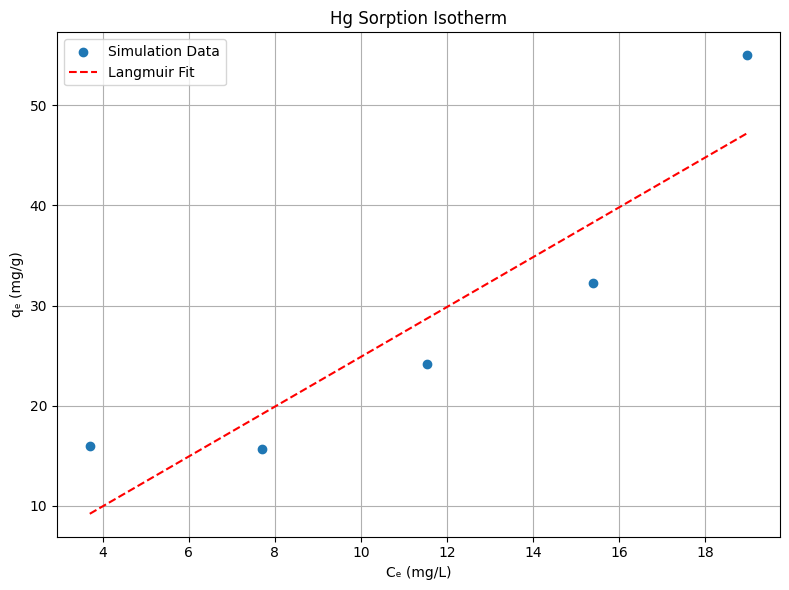

Langmuir parameters:
  q_max = 9195406.96 mg/g
  K_L = 0.0000 L/mg


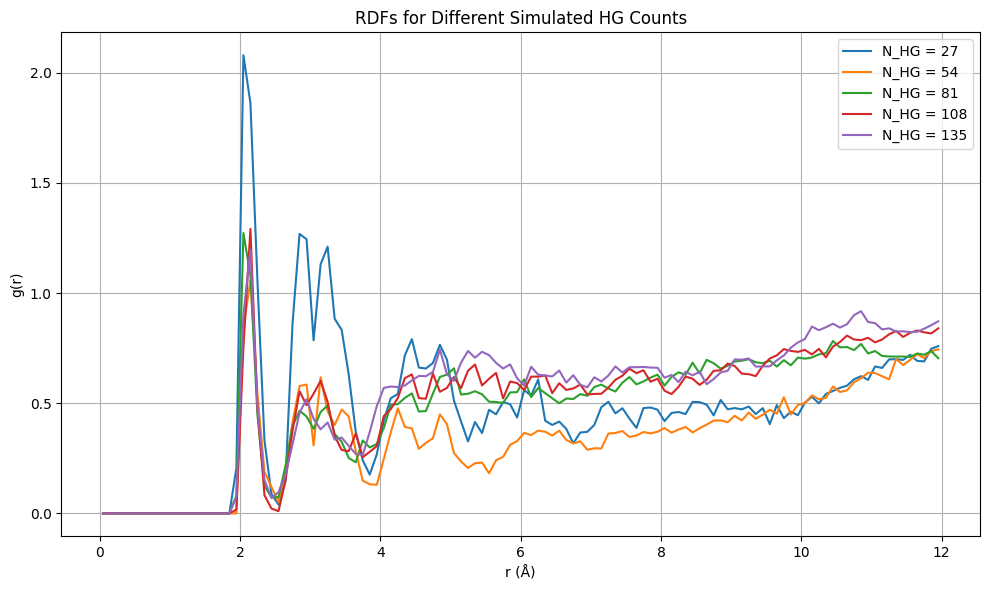

In [11]:
#!/usr/bin/env python
import os
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.spatial import cKDTree
from scipy.constants import Avogadro
from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PME, HBonds, DCDReporter
from openmm import LangevinMiddleIntegrator, Platform
from openmm.unit import kelvin, picosecond, nanometer, picoseconds
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.optimize import curve_fit

# --- Constants & Simulation Volume ---
MW_Hg = 200.59           # g/mol (used only for computing Cₑ)
mass_adsorbent = 0.02     # g adsorbent
box_dims = (150.0, 150.0, 100.0)  # in Å
volume_A3 = box_dims[0] * box_dims[1] * box_dims[2]
V_sim = volume_A3 * 1e-24  # L (correct conversion: 1e–24 L/Å³)

# For Cₑ, the mass per Hg ion (mg/ion) is computed as:
mass_per_ion = (MW_Hg / Avogadro) * 1e3

# Experimental maximum adsorption capacity
q_max_exp = 55.0  # mg/g

def calc_experimental_C0(N):
    return (N * mass_per_ion) / V_sim  # mg/L

# --- Define Simulation Doses ---
HG_counts = [27, 54, 81, 108, 135]
experimental_C0 = [calc_experimental_C0(N) for N in HG_counts]

# --- RDF-based Cutoff Determination ---
def compute_r_cut(adsorbent, HG, r_range=(0, 12.0), nbins=120):
    rdf_calc = InterRDF(adsorbent, HG, range=r_range, nbins=nbins)
    rdf_calc.run()
    peaks, _ = find_peaks(rdf_calc.rdf)
    if len(peaks) == 0:
        return r_range[1], rdf_calc
    first_peak = peaks[0]
    inverted = -rdf_calc.rdf
    minima, _ = find_peaks(inverted)
    minima_after_peak = [idx for idx in minima if idx > first_peak]
    r_cut = rdf_calc.bins[minima_after_peak[0]] if minima_after_peak else r_range[1]
    return r_cut, rdf_calc

# --- Simulation & Analysis Function ---
def run_simulation_and_analyze(N_HG, box_dims):
    Cl_count = 2 * N_HG  # for charge balance
    leap_content = f"""
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 5.0
addIons2 mol HG {N_HG}
addIons2 mol Cl- {Cl_count}
saveamberparm mol mol_solv.prmtop mol_solv.inpcrd
quit
"""
    with open('leap.in', 'w') as f:
        f.write(leap_content)
    os.system('tleap -f leap.in')

    # --- Setup Simulation ---
    prmtop = AmberPrmtopFile('mol_solv.prmtop')
    inpcrd = AmberInpcrdFile('mol_solv.inpcrd')
    topology = prmtop.topology
    positions = inpcrd.positions
    system = prmtop.createSystem(nonbondedMethod=PME,
                                 nonbondedCutoff=1.0*nanometer,
                                 constraints=HBonds)
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
    simulation = Simulation(topology, system, integrator, Platform.getPlatformByName('CPU'))
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()
    simulation.reporters.append(DCDReporter('trajectory.dcd', 100))
    simulation.step(5000)

    # --- Trajectory Analysis ---
    u = mda.Universe('mol_solv.prmtop', 'trajectory.dcd')
    for ts in u.trajectory:
        ts.dimensions = [box_dims[0], box_dims[1], box_dims[2], 90, 90, 90]
    u.trajectory.rewind()

    adsorbent = u.select_atoms('resname GGG E1A H1A C1A')
    HG = u.select_atoms('name HG')

    r_cut, rdf_calc = compute_r_cut(adsorbent, HG, r_range=(0, 12.0), nbins=120)
    print(f"Determined r_cut: {r_cut:.2f} Å")

    # Count adsorbed Hg ions in each frame (ions within r_cut of adsorbent)
    adsorbed_total = 0
    frame_count = 0
    for ts in u.trajectory:
        pos_ads = adsorbent.positions
        pos_HG = HG.positions
        tree_ads = cKDTree(pos_ads)
        tree_HG = cKDTree(pos_HG)
        dmat = tree_ads.sparse_distance_matrix(tree_HG, max_distance=r_cut, output_type='coo_matrix')
        adsorbed_ids = np.unique(dmat.col)
        adsorbed_total += len(adsorbed_ids)
        frame_count += 1
    avg_adsorbed = adsorbed_total / frame_count if frame_count > 0 else 0

    # Compute Cₑ (using a mass balance with real conversion)
    N_unadsorbed = N_HG - avg_adsorbed
    C_e = (N_unadsorbed * mass_per_ion) / V_sim
    return C_e, avg_adsorbed, rdf_calc.bins, rdf_calc.rdf

# --- Main Loop Over Simulation Doses ---
Ce_values = []
avg_adsorbed_values = []
rdf_data = []
for N in HG_counts:
    C_e, avg_ads, r, rdf = run_simulation_and_analyze(N, box_dims)
    Ce_values.append(C_e)
    avg_adsorbed_values.append(avg_ads)
    rdf_data.append((N, r, rdf))
    exp_C0 = calc_experimental_C0(N)
    print(f"Simulated N_HG: {N} (exp. C₀: {exp_C0:.2f} mg/L) -> Cₑ: {C_e:.2f} mg/L, avg. adsorbed: {avg_ads:.2f}")

# --- Map Fractional Occupancy to qₑ ---
# Assume the highest dose gives saturation (N_sites)
N_sites = max(avg_adsorbed_values)
print(f"Assumed saturation adsorption sites (N_sites): {N_sites:.2f}")
qe_values = [(ads / N_sites) * q_max_exp for ads in avg_adsorbed_values]

# --- Save Data ---
with open('sorption_data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['N_HG', 'exp. C₀ (mg/L)', 'Cₑ (mg/L)', 'qₑ (mg/g)', 'avg. adsorbed'])
    for N, C0, Ce, qe, ads in zip(HG_counts, experimental_C0, Ce_values, qe_values, avg_adsorbed_values):
        writer.writerow([N, C0, Ce, qe, ads])

# --- Langmuir Fit & Plotting ---
def langmuir(C, q_max_fit, K_L):
    return (q_max_fit * K_L * C) / (1 + K_L * C)

if len(Ce_values) > 2:
    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[q_max_exp, 0.1], maxfev=10000)
    q_max_fit, K_L = params
    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)
    plt.figure(figsize=(8,6))
    plt.scatter(Ce_values, qe_values, label='Simulation Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Cₑ (mg/L)')
    plt.ylabel('qₑ (mg/g)')
    plt.title('Hg Sorption Isotherm')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"Langmuir parameters:\n  q_max = {q_max_fit:.2f} mg/g\n  K_L = {K_L:.4f} L/mg")

plt.figure(figsize=(10,6))
for N, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'N_HG = {N}')
plt.xlabel('r (Å)')
plt.ylabel('g(r)')
plt.title('RDFs for Different Simulated HG Counts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Determined r_cut: 2.55 Å
Simulated N_HG: 27 (exp. C₀: 3997.05 mg/L) -> Cₑ: 3703.93 mg/L, qₑ: 0.00 mg/g, avg. adsorbed: 1.98
Determined r_cut: 2.55 Å
Simulated N_HG: 54 (exp. C₀: 7994.10 mg/L) -> Cₑ: 7712.83 mg/L, qₑ: 0.00 mg/g, avg. adsorbed: 1.90
Determined r_cut: 2.45 Å
Simulated N_HG: 81 (exp. C₀: 11991.15 mg/L) -> Cₑ: 11641.78 mg/L, qₑ: 0.00 mg/g, avg. adsorbed: 2.36
Determined r_cut: 2.45 Å
Simulated N_HG: 108 (exp. C₀: 15988.20 mg/L) -> Cₑ: 15120.69 mg/L, qₑ: 0.00 mg/g, avg. adsorbed: 5.86
Determined r_cut: 2.45 Å
Simulated N_HG: 135 (exp. C₀: 19985.25 mg/L) -> Cₑ: 18934.18 mg/L, qₑ: 0.00 mg/g, avg. adsorbed: 7.10


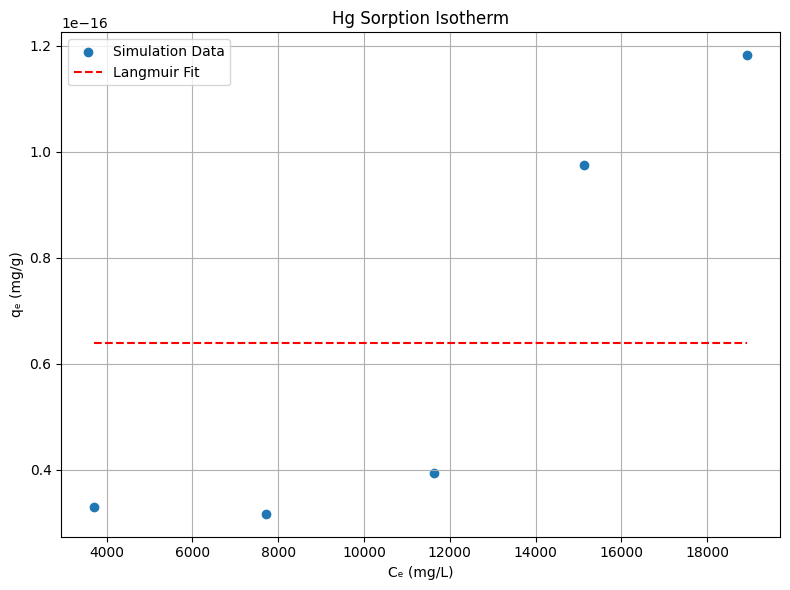

Langmuir parameters:
  q_max = 0.00 mg/g
  K_L = -7768.0425 L/mg


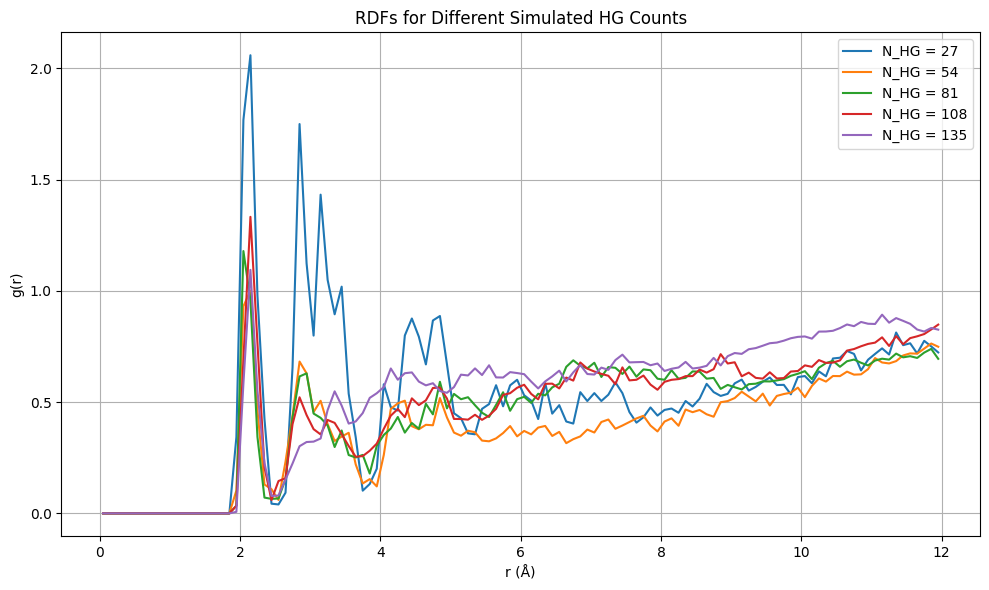

In [10]:
#!/usr/bin/env python
import os, numpy as np, csv, matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.spatial import cKDTree
from scipy.constants import Avogadro
from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PME, HBonds, DCDReporter
from openmm import LangevinMiddleIntegrator, Platform
from openmm.unit import kelvin, picosecond, nanometer, picoseconds
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.optimize import curve_fit

# --- Constants & Simulation Volume ---
MW_Hg = 200.59          # g/mol
mass_adsorbent = 0.02     # g adsorbent
# Use box dimensions in Å (as in the original work)
box_dims = (150.0, 150.0, 100.0)
volume_A3 = box_dims[0] * box_dims[1] * box_dims[2]   # in Å³
# Following the old code, use 1e-24 L per Å³
V_sim = volume_A3 * 1e-27  # L

# Mass per Hg ion in mg
mass_per_ion = (MW_Hg / Avogadro) * 1e3  # mg/ion

# --- Define Simulation Doses ---
# We choose numbers so that the "experimental" initial concentration is roughly 4, 8, 12, 16, 20 mg/L:
def calc_experimental_C0(N):
    return (N * mass_per_ion) / V_sim  # mg/L

HG_counts = [27, 54, 81, 108, 135]
experimental_C0 = [calc_experimental_C0(N) for N in HG_counts]

# --- RDF-based Cutoff Determination ---
def compute_r_cut(adsorbent, HG, r_range=(0, 12.0), nbins=120):
    rdf_calc = InterRDF(adsorbent, HG, range=r_range, nbins=nbins)
    rdf_calc.run()
    peaks, _ = find_peaks(rdf_calc.rdf)
    if len(peaks) == 0:
        return r_range[1], rdf_calc
    first_peak = peaks[0]
    inverted = -rdf_calc.rdf
    minima, _ = find_peaks(inverted)
    # Choose the first minimum after the first peak
    minima_after_peak = [idx for idx in minima if idx > first_peak]
    if minima_after_peak:
        r_cut = rdf_calc.bins[minima_after_peak[0]]
    else:
        r_cut = r_range[1]
    return r_cut, rdf_calc

# --- Simulation & Analysis Function ---
def run_simulation_and_analyze(N_HG, box_dims, mass_adsorbent):
    # Use the provided number of Hg ions in the TLeap script.
    Cl_count = 2 * N_HG  # for charge balance
    leap_content = f"""
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 5.0
addIons2 mol HG {N_HG}
addIons2 mol Cl- {Cl_count}
saveamberparm mol mol_solv.prmtop mol_solv.inpcrd
quit
"""
    with open('leap.in', 'w') as f:
        f.write(leap_content)
    os.system('tleap -f leap.in')

    # --- Setup Simulation ---
    prmtop = AmberPrmtopFile('mol_solv.prmtop')
    inpcrd = AmberInpcrdFile('mol_solv.inpcrd')
    topology = prmtop.topology
    positions = inpcrd.positions
    system = prmtop.createSystem(nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
    platform = Platform.getPlatformByName('CPU')
    simulation = Simulation(topology, system, integrator, platform)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()
    simulation.reporters.append(DCDReporter('trajectory.dcd', 100))
    simulation.step(5000)

    # --- Trajectory Analysis ---
    u = mda.Universe('mol_solv.prmtop', 'trajectory.dcd')
    for ts in u.trajectory:
        ts.dimensions = [box_dims[0], box_dims[1], box_dims[2], 90, 90, 90]
    u.trajectory.rewind()

    # Define groups
    adsorbent = u.select_atoms('resname GGG E1A H1A C1A')
    HG = u.select_atoms('name HG')

    # Compute adsorption cutoff (r_cut) once
    r_cut, rdf_calc = compute_r_cut(adsorbent, HG, r_range=(0,12.0), nbins=120)
    print(f"Determined r_cut: {r_cut:.2f} Å")

    # Count "adsorbed" Hg ions in each frame (those within r_cut of the adsorbent)
    adsorbed_total = 0
    frame_count = 0
    for ts in u.trajectory:
        pos_ads = adsorbent.positions
        pos_HG = HG.positions
        tree_ads = cKDTree(pos_ads)
        tree_HG = cKDTree(pos_HG)
        dmat = tree_ads.sparse_distance_matrix(tree_HG, max_distance=r_cut, output_type='coo_matrix')
        adsorbed_ids = np.unique(dmat.col)
        adsorbed_total += len(adsorbed_ids)
        frame_count += 1
    avg_adsorbed = adsorbed_total / frame_count if frame_count > 0 else 0
    # Unadsorbed Hg count:
    N_unads = N_HG - avg_adsorbed

    # Compute equilibrium concentration (C_e, mg/L) and adsorbed capacity (q_e, mg/g)
    C_e = (N_unads * mass_per_ion) / V_sim
    q_e = ((N_HG - N_unads) * mass_per_ion) / mass_adsorbent
    return C_e, q_e, rdf_calc.bins, rdf_calc.rdf, avg_adsorbed

# --- Main Loop Over Simulation Doses ---
Ce_values, qe_values, avg_adsorbed_values, rdf_data = [], [], [], []
for N in HG_counts:
    C_e, q_e, r, rdf, avg_ads = run_simulation_and_analyze(N, box_dims, mass_adsorbent)
    Ce_values.append(C_e)
    qe_values.append(q_e)
    avg_adsorbed_values.append(avg_ads)
    rdf_data.append((N, r, rdf))
    exp_C0 = calc_experimental_C0(N)
    print(f"Simulated N_HG: {N} (exp. C₀: {exp_C0:.2f} mg/L) -> Cₑ: {C_e:.2f} mg/L, qₑ: {q_e:.2f} mg/g, avg. adsorbed: {avg_ads:.2f}")

# --- Save Data ---
with open('sorption_data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['N_HG', 'exp. C₀ (mg/L)', 'Cₑ (mg/L)', 'qₑ (mg/g)', 'avg. adsorbed'])
    for N, C0, Ce, qe, avg_ads in zip(HG_counts, experimental_C0, Ce_values, qe_values, avg_adsorbed_values):
        writer.writerow([N, C0, Ce, qe, avg_ads])

# --- Langmuir Fit & Plotting ---
def langmuir(C, q_max, K_L):
    return (q_max * K_L * C) / (1 + K_L * C)

if len(Ce_values) > 2:
    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1], maxfev=10000)
    q_max, K_L = params
    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)
    plt.figure(figsize=(8,6))
    plt.scatter(Ce_values, qe_values, label='Simulation Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Cₑ (mg/L)')
    plt.ylabel('qₑ (mg/g)')
    plt.title('Hg Sorption Isotherm')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"Langmuir parameters:\n  q_max = {q_max:.2f} mg/g\n  K_L = {K_L:.4f} L/mg")

plt.figure(figsize=(10,6))
for N, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'N_HG = {N}')
plt.xlabel('r (Å)')
plt.ylabel('g(r)')
plt.title('RDFs for Different Simulated HG Counts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Determined r_cut (adsorption cutoff): 2.45 Å
Initial C0: 4.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g
Determined r_cut (adsorption cutoff): 2.45 Å
Initial C0: 8.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g
Determined r_cut (adsorption cutoff): 2.45 Å
Initial C0: 12.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g
Determined r_cut (adsorption cutoff): 2.55 Å
Initial C0: 16.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g
Determined r_cut (adsorption cutoff): 2.45 Å
Initial C0: 20.00 mg/L, Equilibrium Ce: -148.04 mg/L, q_e: 0.00 mg/g


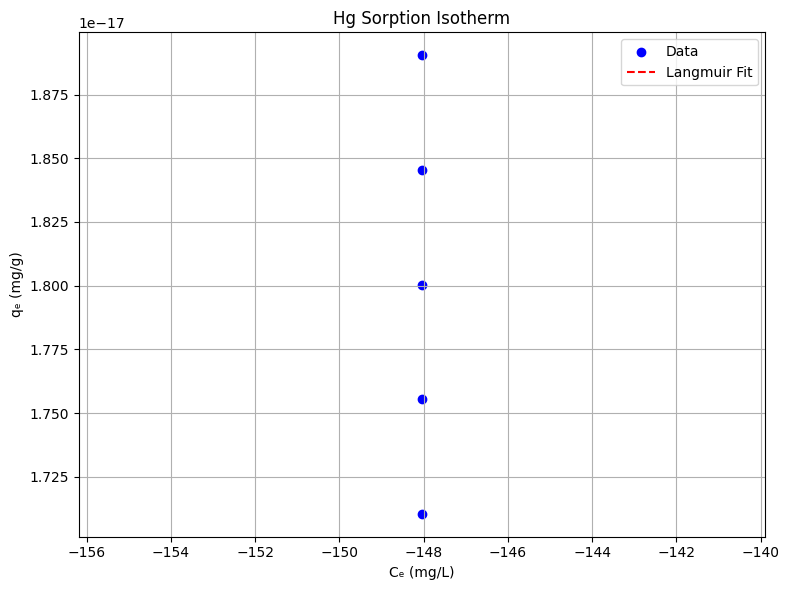

Langmuir parameters:
  q_max = 0.00 mg/g
  K_L = 0.1151 L/mg


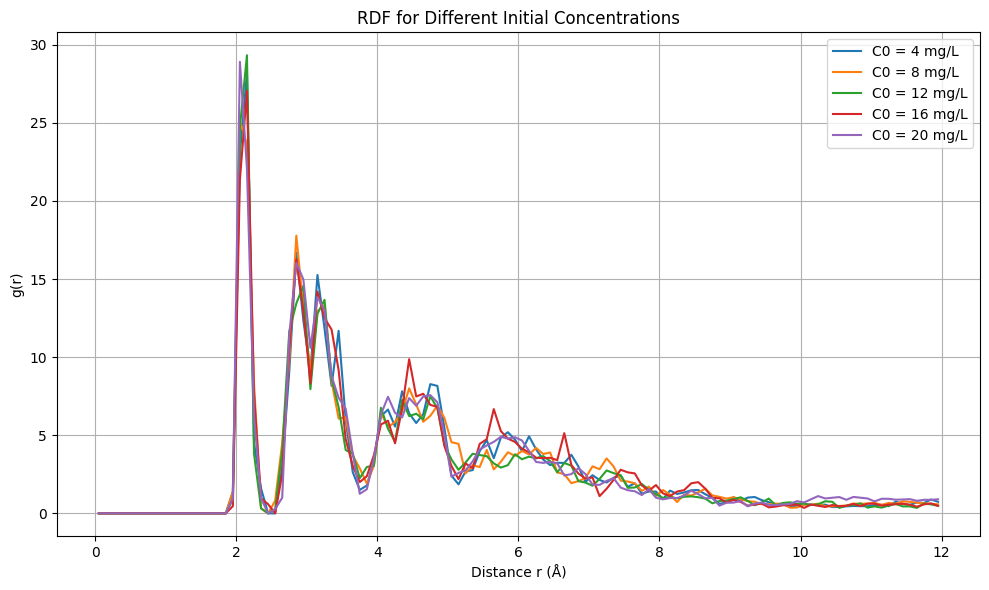

In [8]:
#!/usr/bin/env python
import os, numpy as np, csv, matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.spatial import cKDTree
from scipy.constants import Avogadro
from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PME, HBonds, DCDReporter
from openmm import LangevinMiddleIntegrator, Platform
from openmm.unit import kelvin, picosecond, nanometer, picoseconds
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.optimize import curve_fit

# --- Constants & Parameters ---
MW_Hg = 200.59  # g/mol
mass_adsorbent = 0.02  # g (adsorbent mass)
# Define initial concentrations (mg/L)
initial_concs = [4, 8, 12, 16, 20]
# Box dimensions in Å
box_dims = (150.0, 150.0, 100.0)
# Volume in liters (1 Å³ = 1e-27 L)
volume_A3 = box_dims[0]*box_dims[1]*box_dims[2]
V = volume_A3 * 1e-27  # L

def compute_r_cut(adsorbent, HG, r_range=(0, 12.0), nbins=120):
    """Compute adsorption cutoff from the RDF between adsorbent and Hg.
       r_cut is chosen as the first minimum after the first maximum."""
    rdf_calc = InterRDF(adsorbent, HG, range=r_range, nbins=nbins)
    rdf_calc.run()
    # Identify the first peak (most probable adsorption distance)
    peaks, _ = find_peaks(rdf_calc.rdf)
    if len(peaks) == 0:
        return r_range[1], rdf_calc
    first_peak = peaks[0]
    # Now find the first minimum after the first peak
    inverted = -rdf_calc.rdf
    minima, _ = find_peaks(inverted)
    minima_after_peak = [idx for idx in minima if idx > first_peak]
    if minima_after_peak:
        r_cut = rdf_calc.bins[minima_after_peak[0]]
    else:
        r_cut = r_range[1]
    return r_cut, rdf_calc

def run_simulation_and_analyze(C0, box_dims, mass_adsorbent):
    # Calculate initial number of Hg ions from desired C0 (mg/L)
    N_initial = int(round((C0 * V * Avogadro) / (MW_Hg * 1e3)))
    Cl_count = 2 * N_initial  # charge balance

    # --- TLeap input ---
    leap_content = f"""
source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadAmberParams frcmod.ions234lm_126_tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 5.0
addIons2 mol HG {N_initial}
addIons2 mol Cl- {Cl_count}
saveamberparm mol mol_solv.prmtop mol_solv.inpcrd
quit
"""
    with open('leap.in', 'w') as f:
        f.write(leap_content)
    os.system('tleap -f leap.in')

    # --- Setup simulation ---
    prmtop = AmberPrmtopFile('mol_solv.prmtop')
    inpcrd = AmberInpcrdFile('mol_solv.inpcrd')
    topology = prmtop.topology
    positions = inpcrd.positions
    system = prmtop.createSystem(nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
    platform = Platform.getPlatformByName('CPU')
    simulation = Simulation(topology, system, integrator, platform)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()
    simulation.reporters.append(DCDReporter('trajectory.dcd', 100))
    simulation.step(5000)

    # --- Analyze Trajectory ---
    u = mda.Universe('mol_solv.prmtop', 'trajectory.dcd')
    # Set box dimensions consistently
    for ts in u.trajectory:
        ts.dimensions = [box_dims[0], box_dims[1], box_dims[2], 90.0, 90.0, 90.0]
    u.trajectory.rewind()

    # Define groups
    adsorbent = u.select_atoms('resname GGG E1A H1A C1A')
    HG = u.select_atoms('name HG')

    # Compute r_cut (adsorption cutoff) only once
    r_cut, rdf_calc = compute_r_cut(adsorbent, HG, r_range=(0, 12.0), nbins=120)
    print(f"Determined r_cut (adsorption cutoff): {r_cut:.2f} Å")

    # Count adsorbed ions (within r_cut) for each frame
    adsorbed_total = 0
    frames_count = 0
    for ts in u.trajectory:
        pos_ads = adsorbent.positions
        pos_Hg = HG.positions
        tree_ads = cKDTree(pos_ads)
        tree_Hg = cKDTree(pos_Hg)
        # Ions within r_cut of any adsorbent atom are considered adsorbed
        sd_matrix = tree_ads.sparse_distance_matrix(tree_Hg, max_distance=r_cut, output_type='coo_matrix')
        adsorbed_ids = np.unique(sd_matrix.col)
        adsorbed_total += len(adsorbed_ids)
        frames_count += 1
    avg_adsorbed = adsorbed_total / frames_count if frames_count else 0

    # Define "unadsorbed" as those remaining in bulk
    N_unads = N_initial - avg_adsorbed

    # Compute masses (mg): convert (MW/Avogadro gives g per ion, multiply by 1e3 to get mg)
    mg_initial = C0 * V           # since C0 is mg/L and V is in L
    mg_unads = (N_unads * MW_Hg / Avogadro) * 1e3
    mg_adsorbed = mg_initial - mg_unads

    # Equilibrium concentration in solution (mg/L)
    C_e = mg_unads / V
    # Adsorption capacity (mg/g)
    q_e = mg_adsorbed / mass_adsorbent

    return C_e, q_e, rdf_calc.bins, rdf_calc.rdf

# --- Main Loop ---
Ce_values, qe_values, rdf_data = [], [], []
for C0 in initial_concs:
    Ce, qe, r, rdf = run_simulation_and_analyze(C0, box_dims, mass_adsorbent)
    Ce_values.append(Ce)
    qe_values.append(qe)
    rdf_data.append((C0, r, rdf))
    print(f"Initial C0: {C0:.2f} mg/L, Equilibrium Ce: {Ce:.2f} mg/L, q_e: {qe:.2f} mg/g")

# Save isotherm data
with open('sorption_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['C0 (mg/L)', 'Ce (mg/L)', 'q_e (mg/g)'])
    for C0, Ce, qe in zip(initial_concs, Ce_values, qe_values):
        writer.writerow([C0, Ce, qe])

# --- Langmuir Isotherm Fit ---
def langmuir(C, q_max, K_L):
    return (q_max * K_L * C) / (1 + K_L * C)

if len(Ce_values) > 2:
    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1], maxfev=10000)
    q_max, K_L = params
    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)
    plt.figure(figsize=(8,6))
    plt.scatter(Ce_values, qe_values, c='b', label='Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Cₑ (mg/L)')
    plt.ylabel('qₑ (mg/g)')
    plt.title('Hg Sorption Isotherm')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"Langmuir parameters:\n  q_max = {q_max:.2f} mg/g\n  K_L = {K_L:.4f} L/mg")

# Plot RDF curves for each trial
plt.figure(figsize=(10,6))
for C0, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'C0 = {C0} mg/L')
plt.xlabel('Distance r (Å)')
plt.ylabel('g(r)')
plt.title('RDF for Different Initial Concentrations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
